In [1]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/Bayesian-Filtering-and-Smoothing


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from filters.kalman_filter import *
from filters.extended_kalman_filter import *
from filters.particle_filter import *
from models.pendulum import *

## Define the Pendulum

In [4]:
dt = 0.01
R = np.array([[0.1]]) # measurement noise

pendulum_system = make_true_pendulum_system(dt = dt,
                                            R = R)

## Generate Data

500


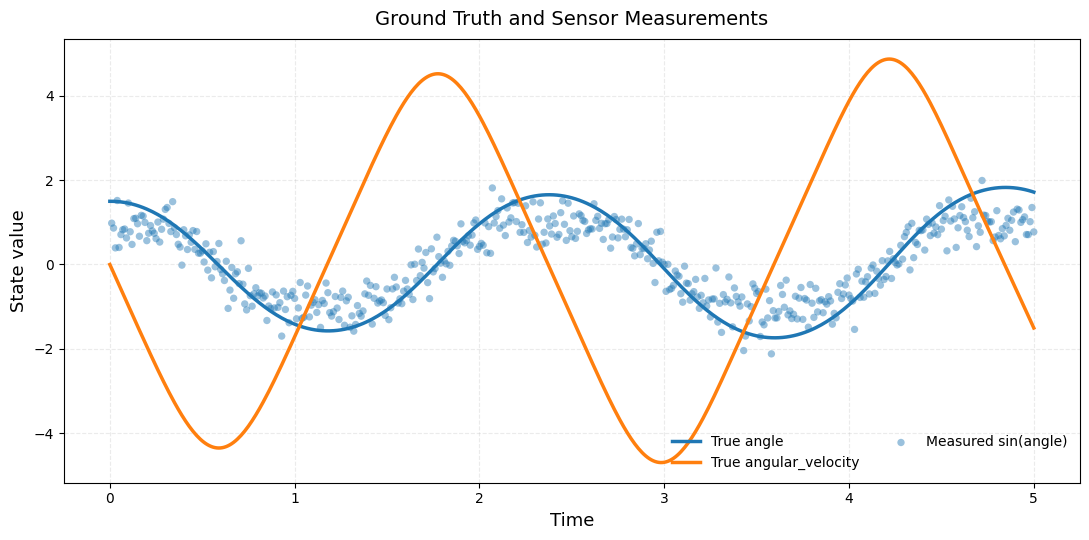

In [5]:
# ============================================================
# 0. Random number generator
# ============================================================
rng = np.random.default_rng(seed=None)  # non-deterministic runs

# ============================================================
# 1. Ground-truth system definition (reality)
# ============================================================
x0 = np.array([1.5, 0.0])  # true initial state

T = 5.0
Nsims = int(T / dt)
times = np.linspace(0.0, T, Nsims + 1)

print(Nsims)
# Observe at every step except t0
delta = 1
obs_ind = np.arange(delta,times.shape[0], delta)

# ============================================================
# 2. Generate ground truth and synthetic sensor data
# ============================================================
truth, measurements = generate_nonlinear_data(
    times=times,
    x0=x0,
    obs_ind=obs_ind,
    system=pendulum_system,     # TrueNonLinearSystem
    rng=rng
)

plot_data_and_truth(
    truth,
    measurements,
    title="Ground Truth and Sensor Measurements"
)

In [6]:
import scipy.stats as stats

def gaussian_logpdf(x, mean, cov):
    return stats.multivariate_normal.logpdf(x, mean=mean, cov=cov)

# ============================================================
# 3. Bootstrap Particle Filter design (estimator's belief)
# ============================================================

dt = 0.01
qc = 0.1

Q = pendulum_process_noise_cov(dt, qc)
R = R  # measurement noise covariance already defined

def bootstrap_proposal_sampler(traj_prev, rng):
    """
    Sample x_k ~ p(x_k | x_{k-1})
    """
    if traj_prev is None:
        # Initial prior: x_0 ~ N(x0, I)
        return rng.multivariate_normal(mean=x0, cov=np.eye(2))
    
    x_prev = traj_prev[-1]
    mean = pendulum_dynamics(x_prev, dt)
    return rng.multivariate_normal(mean=mean, cov=Q)

def bootstrap_proposal_logpdf(x_curr, traj_prev):
    if traj_prev is None:
        return gaussian_logpdf(x_curr, x0, np.eye(2))
    
    x_prev = traj_prev[-1]
    mean = pendulum_dynamics(x_prev, dt)
    return gaussian_logpdf(x_curr, mean, Q)

def transition_logpdf(x_curr, x_prev):
    mean = pendulum_dynamics(x_prev, dt)
    return gaussian_logpdf(x_curr, mean, Q)

def measurement_logpdf(y, x):
    mean = pendulum_measurement(x)
    return gaussian_logpdf(y, mean, R)


In [7]:
def particle_filter_mean(particleset: ParticleSet) -> np.ndarray:
    """
    Compute weighted marginal filtering mean at each time step.

    Returns:
        means : (T, d)
    """
    particleset.normalize()
    X = particleset.particles      # (N, T, d)
    w = particleset.weights        # (N,)
    return np.sum(X * w[:, None, None], axis=0)

def plot_particle_filter_results(
    truth: Observations,
    measurements: Observations,
    particleset: ParticleSet,
    title: str = "Bootstrap Particle Filter State Estimation",
    max_particles_to_plot: int = 200
):
    """
    Quick visualization for Particle Filter results.

    Shows:
    - Ground truth (solid)
    - Measurements (scatter)
    - Particle cloud (light scatter)
    - Weighted particle mean (dashed)

    This is NOT publication quality.
    It is meant for debugging and intuition.
    """

    X = particleset.particles      # (N, T, d)
    w = particleset.weights
    T = X.shape[1]
    d = X.shape[2]

    times = truth.times
    pf_mean = particle_filter_mean(particleset)

    fig, ax = plt.subplots(figsize=(11, 5.5))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # -------------------------
    # Ground truth
    # -------------------------
    for i in range(d):
        ax.plot(
            times,
            truth.obs[:, i],
            color=colors[i],
            linewidth=2.5,
            label=f"True {truth.names[i]}"
        )

    # -------------------------
    # Measurements
    # -------------------------
    for i in range(measurements.obs.shape[1]):
        ax.scatter(
            times[measurements.obs_ind],
            measurements.obs[:, i],
            color=colors[i],
            alpha=0.45,
            s=28,
            label=f"Measured {measurements.names[i]}"
        )

    # -------------------------
    # Particle cloud (subsampled)
    # -------------------------
    # -------------------------
    # Particle cloud (subsampled)
    # -------------------------
    N = X.shape[0]
    idx = np.random.choice(
        N,
        size=min(N, max_particles_to_plot),
        replace=False
    )

    for i in range(d):
        # Repeat times for each particle
        t_rep = np.tile(times, len(idx))          # (M*T,)
        x_rep = X[idx, :, i].reshape(-1)           # (M*T,)

        ax.scatter(
            t_rep,
            x_rep,
            color=colors[i],
            alpha=0.05,
            s=5
        )

    # -------------------------
    # Particle filter mean
    # -------------------------
    for i in range(d):
        ax.plot(
            times,
            pf_mean[:, i],
            linestyle="--",
            linewidth=2.0,
            color=colors[i],
            label=f"PF mean {truth.names[i]}"
        )

    # -------------------------
    # Styling
    # -------------------------
    ax.set_xlabel("Time", fontsize=13)
    ax.set_ylabel("State value", fontsize=13)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.25)
    ax.legend(frameon=False, fontsize=10, ncol=2)

    fig.tight_layout()
    plt.show()


In [8]:
pf_model = ParticleFilterModel(
    Phi= lambda x: pendulum_dynamics(x, dt),
    h= pendulum_measurement,
    proposal_sampler= bootstrap_proposal_sampler,
    proposal_logpdf= bootstrap_proposal_logpdf,
    transition_logpdf= transition_logpdf,
    measurement_logpdf= measurement_logpdf,
    ess_threshold_ratio=0.5
)

In [9]:
num_particles = 2000
rng = np.random.default_rng(seed=None)

pf_result = run_particle_filter(
    y_observations=measurements,
    model=pf_model,
    num_particles=num_particles,
    rng=rng
)


1 501
2 501
3 501
4 501
5 501
6 501
7 501
8 501
9 501
10 501
11 501
12 501
13 501
14 501
15 501
16 501
17 501
18 501
19 501
20 501
21 501
22 501
23 501
24 501
25 501
26 501
27 501
28 501
29 501
30 501
31 501
32 501
33 501
34 501
35 501
36 501
37 501
38 501
39 501
40 501
41 501
42 501
43 501
44 501
45 501
46 501
47 501
48 501
49 501
50 501
51 501
52 501
53 501
54 501
55 501
56 501
57 501
58 501
59 501
60 501
61 501
62 501
63 501
64 501
65 501
66 501
67 501
68 501
69 501
70 501
71 501
72 501
73 501
74 501
75 501
76 501
77 501
78 501
79 501
80 501
81 501
82 501
83 501
84 501
85 501
86 501
87 501
88 501
89 501
90 501
91 501
92 501
93 501
94 501
95 501
96 501
97 501
98 501
99 501
100 501
101 501
102 501
103 501
104 501
105 501
106 501
107 501
108 501
109 501
110 501
111 501
112 501
113 501
114 501
115 501
116 501
117 501
118 501
119 501
120 501
121 501
122 501
123 501
124 501
125 501
126 501
127 501
128 501
129 501
130 501
131 501
132 501
133 501
134 501
135 501
136 501
137 501
138 501
139 

In [10]:
X_T = pf_result.particles[:, -1, :]   # (N, d)
w_T = pf_result.weights

mean_pf = np.sum(X_T * w_T[:, None], axis=0)


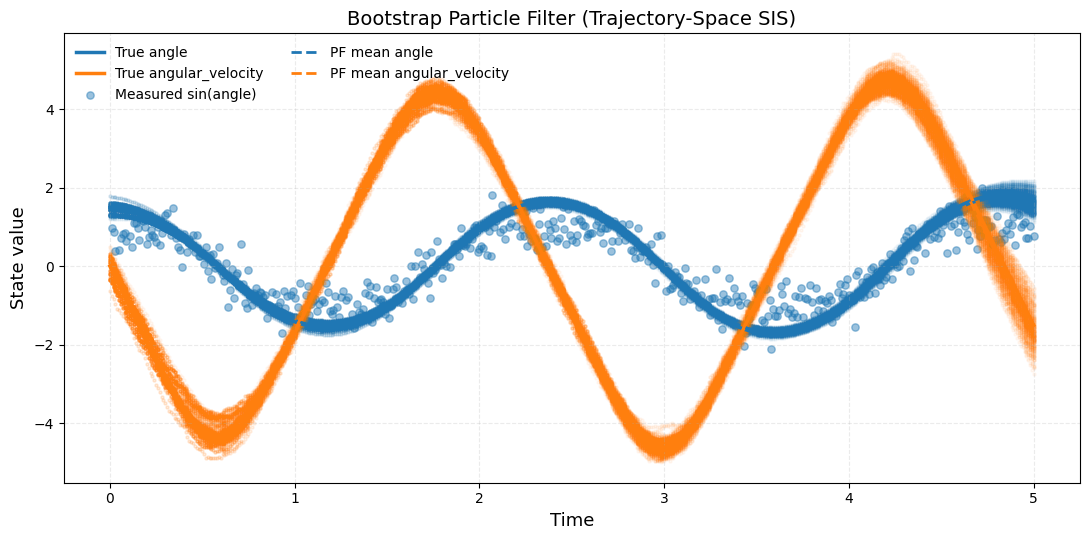

In [11]:
plot_particle_filter_results(
    truth=truth,
    measurements=measurements,
    particleset=pf_result,
    title="Bootstrap Particle Filter (Trajectory-Space SIS)"
)